# 第十五週 word2vec

大綱：使用PTT的美食版，計算出word2vec的模型

In [1]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing

# import spacy
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors   

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

import seaborn as sns
sns.set_style("darkgrid")


In [2]:
# 前幾週有處理完的資料
metaData = pd.read_csv('./raw_data/clean_zh_data.csv')
metaData.word = metaData.word.astype(str)
metaData = metaData[~metaData.word.str.isdecimal()]
metaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[食記]台北中山徐淮人家重口味北方菜不吃辣不要來好下飯,2023/01/31,19:11:08,https://www.ptt.cc/bbs/Food/M.1675192271.A.E0C...,AlphaD,Food,13,7,0,餐廳名稱徐淮人家 消費時間2023年1月10491台北市中山區遼寧街45巷2號11am2pm,餐廳
1,[食記]台北中山徐淮人家重口味北方菜不吃辣不要來好下飯,2023/01/31,19:11:08,https://www.ptt.cc/bbs/Food/M.1675192271.A.E0C...,AlphaD,Food,13,7,0,餐廳名稱徐淮人家 消費時間2023年1月10491台北市中山區遼寧街45巷2號11am2pm,徐淮
2,[食記]台北中山徐淮人家重口味北方菜不吃辣不要來好下飯,2023/01/31,19:11:08,https://www.ptt.cc/bbs/Food/M.1675192271.A.E0C...,AlphaD,Food,13,7,0,餐廳名稱徐淮人家 消費時間2023年1月10491台北市中山區遼寧街45巷2號11am2pm,消費


In [3]:
# 把斷詞重新拼回
metaData = metaData.groupby('sentence')['word'].apply(list)
metaData = metaData.reset_index()
metaData

,sentence,word
0,中午11301430 ...,"[中午, 晚餐, 每人, 平均, 價位, 可否, 刷卡, 包廂, 推薦, 菜色, 版上, 發..."
1,再加水資80元與10服務費,"[再加, 水資, 服務費]"
2,2只開放轉讓,"[開放, 轉讓, 開放, 轉讓, 開放, 轉讓, 開放, 轉讓]"
3,以下優先順序 1 214 2位 1945之...,"[以下, 優先, 順序, 之後, 涮涮鍋, 訂位, 之後, 餐廳, 訂位, 無條件, 轉讓,..."
4,各項均為必填資料,"[各項, 必填, 資料]"
...,...,...
40671,Ｄ組合 160套餐裡有海苔豆皮大蝦小卷丁龍蝦沙拉魚子醬水果壽司,"[組合, 套餐, 裡有, 海苔, 豆皮, 大蝦, 小卷, 龍蝦, 沙拉, 魚子醬, 水果, 壽司]"
40672,ＰＳ 仙迪排骨是遷移過來的,"[仙迪, 排骨, 遷移, 過來]"
40673,Ｑ彈多汁 阿基里斯腱覺得較雞蠔肉口感再軟嫩一點 雞火腿風乾並煎至半生熟,"[多汁, 阿基里斯, 較雞, 蠔肉, 口感, 軟嫩, 一點, 火腿, 風乾, 並煎, 半生]"
40674,Ｑ彈的糰子本身沒有太多的味道,"[彈的, 糰子, 太多, 味道]"


建立bigram

In [4]:
docs = ['new york is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# Phrases 建立bigram,
# 少於min_count的字的字或bigrams會被忽略,
# 大於threshold的bigrams會被加入
bigram = Phrases(token_, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram) 

for sent in token_:
    print(sent)  #處理前
    print("=> ",bigram_phraser[sent]) # 處理後，還是原本的句子，只是有抓出的bigram片語會被合併

['new', 'york', 'is', 'united', 'states']
=>  ['new_york', 'is', 'united', 'states']
['new', 'york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
=>  ['new_york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
['i', 'love', 'to', 'stay', 'in', 'new', 'york']
=>  ['i', 'love', 'to', 'stay', 'in', 'new_york']


In [5]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,sentence,word,word_list_bigrams
0,中午11301430 ...,"[中午, 晚餐, 每人, 平均, 價位, 可否, 刷卡, 包廂, 推薦, 菜色, 版上, 發...","[中午, 晚餐, 每人, 平均, 價位, 可否, 刷卡, 包廂, 推薦, 菜色, 版上, 發..."
1,再加水資80元與10服務費,"[再加, 水資, 服務費]","[再加, 水資, 服務費]"
2,2只開放轉讓,"[開放, 轉讓, 開放, 轉讓, 開放, 轉讓, 開放, 轉讓]","[開放, 轉讓, 開放, 轉讓, 開放, 轉讓, 開放, 轉讓]"
3,以下優先順序 1 214 2位 1945之...,"[以下, 優先, 順序, 之後, 涮涮鍋, 訂位, 之後, 餐廳, 訂位, 無條件, 轉讓,...","[以下, 優先, 順序, 之後, 涮涮鍋, 訂位, 之後, 餐廳, 訂位, 無條件, 轉讓,..."
4,各項均為必填資料,"[各項, 必填, 資料]","[各項, 必填, 資料]"


In [6]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [7]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 32438


['時間', '餐廳', '地址', '消費', '電話', '口感', '價位', '好吃', '圖文', '推薦']

In [8]:
print(f"sentence number of corpus: {len(sents)}")
i= 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 40676
average length of sentences: 5.670518241715016


Word2Vec 計算

In [9]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [10]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 16


In [11]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                    #  negative=20,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax 
                     )

查看結果

In [12]:
# 檢查最相關的字
w2v_model.wv.most_similar('餐廳',topn=10)

[('料理', 0.8275566101074219),
 ('鍋物', 0.8146036863327026),
 ('燒肉', 0.8129338026046753),
 ('早午餐', 0.8109743595123291),
 ('鐵板燒', 0.809908390045166),
 ('專賣店', 0.8042067289352417),
 ('咖啡廳', 0.7990747094154358),
 ('高雄', 0.7870111465454102),
 ('拉麵', 0.785632312297821),
 ('小吃', 0.7842945456504822)]

In [13]:
w2v_model.wv.most_similar('咖啡廳',topn=10)

[('鍋物', 0.9373326301574707),
 ('酒館', 0.936203122138977),
 ('廚房', 0.9223772883415222),
 ('居酒屋', 0.9193955063819885),
 ('Coffee', 0.9181528687477112),
 ('吃飯', 0.9102323651313782),
 ('燒肉', 0.9091059565544128),
 ('早餐', 0.9088218212127686),
 ('飯店', 0.9079596996307373),
 ('來到', 0.9077345132827759)]

In [14]:
w2v_model.wv.most_similar(['咖啡廳','餐廳'],topn=10)

[('鍋物', 0.9235889315605164),
 ('燒肉', 0.9078280329704285),
 ('專賣店', 0.8982645273208618),
 ('早午餐', 0.8973844647407532),
 ('鐵板燒', 0.896811306476593),
 ('小吃', 0.8909664154052734),
 ('廚房', 0.8907731771469116),
 ('酒館', 0.8897709250450134),
 ('高雄', 0.8823962211608887),
 ('食堂', 0.8804399967193604)]

In [15]:
w2v_model.wv.most_similar(negative=['咖啡廳','餐廳'],topn=10)

[('口感', -0.09432462602853775),
 ('酥脆', -0.13178667426109314),
 ('吃起來', -0.13989874720573425),
 ('香氣', -0.14996957778930664),
 ('肉質', -0.1940537989139557),
 ('一口', -0.19832998514175415),
 ('軟嫩', -0.20483270287513733),
 ('清爽', -0.2056044638156891),
 ('新鮮', -0.20612512528896332),
 ('帶有', -0.2074534296989441)]

In [16]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("台北","台南")

0.95705456

In [17]:
w2v_model.wv.similarity("口感","香氣")

0.910524

In [18]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["口感", "香氣", '台北'])

'台北'

In [19]:
# 相對關係
w2v_model.wv.most_similar(positive=["台北", "口感"], negative=["香氣"], topn=5)

[('台南', 0.901310920715332),
 ('鐵板燒', 0.8821651935577393),
 ('食堂', 0.8756908774375916),
 ('店名', 0.8752586245536804),
 ('台中', 0.8645978569984436)]

In [20]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字的關係及將自分群

In [70]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSEN":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)
    
    return new_feat


In [71]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)
    

In [72]:
getVecs(w2v_model,['餐廳','美食'])

array([[-1.08974643e-01,  4.18679178e-01, -3.70367169e-01,
         5.21069229e-01,  8.37716639e-01,  2.19686612e-01,
         2.51884013e-01, -3.71761769e-01,  2.03503162e-01,
        -3.68694097e-01,  4.86964583e-01, -3.54530573e-01,
        -4.76362020e-01,  2.11047903e-01, -4.27896649e-01,
         3.13590884e-01,  4.30471987e-01, -1.61063015e-01,
         2.99921989e-01, -2.12335452e-01,  2.84610949e-02,
         4.60236043e-01, -2.97347754e-01,  2.35425264e-01,
        -4.88157749e-01,  6.13276139e-02,  6.95500756e-03,
         4.12658930e-01, -2.33490933e-02, -8.89830664e-02,
         4.16503549e-01,  3.18048686e-01,  3.44423890e-01,
        -3.02581549e-01, -3.48727219e-02, -5.37953293e-03,
         2.25675479e-01, -8.63607883e-01, -7.71734238e-01,
        -3.41899306e-01,  1.22931615e-01,  9.99026895e-02,
         2.66099632e-01,  2.35230803e-01, -3.41368645e-01,
        -3.47375333e-01,  2.82305837e-01,  6.40308380e-01,
         2.67963648e-01, -4.51743484e-01,  4.04515743e-0

In [73]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):
    
    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []
    
    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [74]:
expandPosWord(w2v_model,['餐廳','咖啡廳'],top_n = 10)

['高雄',
 '咖啡廳',
 '廚房',
 '鍋物',
 '來到',
 '專賣店',
 '小吃',
 '酒館',
 '居酒屋',
 '早午餐',
 'Coffee',
 '拉麵',
 '鐵板燒',
 '料理',
 '吃飯',
 '飯店',
 '燒肉',
 '早餐']

In [100]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./raw_data/TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'
    
    p = sns.scatterplot(x="dim1", y="dim2", 
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [76]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSEN',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [77]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1], 
})

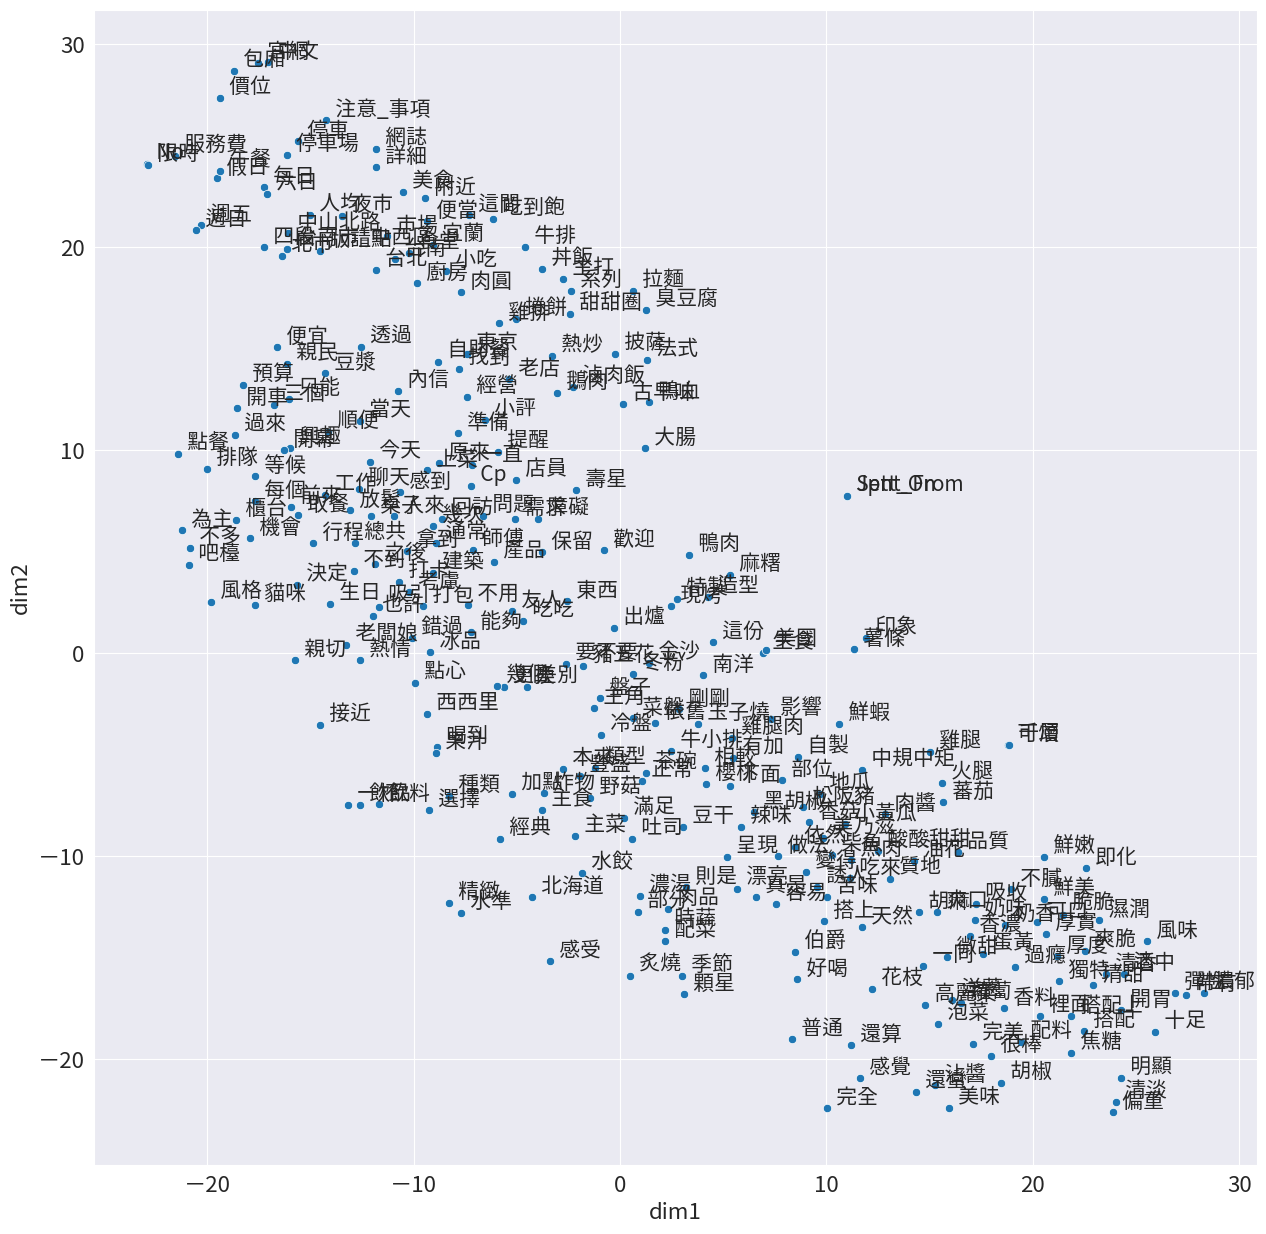

In [78]:
plotScatter(word_df)

In [101]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2], 
})
plotScatter3D(word_df)

(300, 3)


In [81]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):
    
    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [104]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1], 
    "dim3":d3_feat[:,2], 

})
plotScatter3D(word_df)


/home/junhong/.conda/envs/SMA/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

